In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as matplot

from matplotlib import pyplot as plt
from matplotlib.pyplot import show
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
sub_df=pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
test_df=pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
print(train_df.shape)
print(test_df.shape)


(891, 12)
(418, 11)


The training dataset has 891 records and test_df has 418 records. The test dataset has 1 column in short since the target column is excluded

In [8]:
# Checking for null values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

The column Cabin has more than 70% of the records with null values in both train and test dataset
Imputing this column will not be helpful, so deleting this column

In [10]:
train_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)


The age and Embarked columns has null values in training dataset which needs to be imputed. 
Similarly Age and Fare dataset has null values. 

In [11]:
train_df[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


Both the records belong to same ticket, which means they are travelling together and we can see they were in class 1. 
imputing the column with most repeated value using mode.

In [12]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0],inplace=True)

In [13]:
train_df['Age'].fillna(train_df['Age'].median(),inplace=True) # imputing with mdeian as there are some outlier, since only few people have travelled whose age is close to eighty. using mean will not be suitable

In [14]:
test_df['Age'].fillna(test_df['Age'].median(),inplace=True) # imputing with mdeian as there are some outlier, since only few people have travelled whose age is close to eighty. using mean will not be suitable

We can remove the columns id and Name as it will not be helpful for our analysis 

In [15]:
train_df.drop(['Name'],axis=1,inplace=True)
test_df.drop(['Name'],axis=1,inplace=True)

In [16]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,891.0,29.361582,13.019697,0.42,22.0000,28.0000,35.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [17]:
#sns.pairplot(train_df,hue='Survived')

Univariant analysis, Bivariant and multivariant analysis

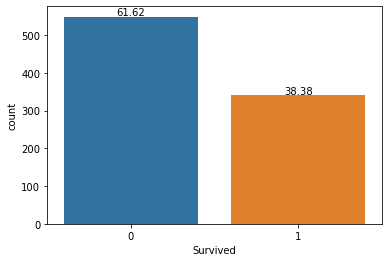

In [18]:

total = float(len(train_df))
ax = sns.countplot(train_df['Survived']) # for Seaborn version 0.7 and more
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
show()

The graph above shows only 38.38% of people have survided

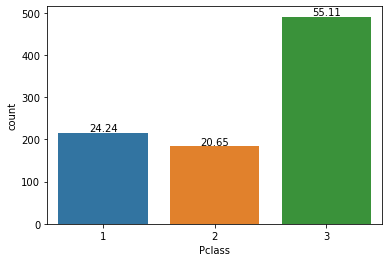

In [19]:
total = float(len(train_df))
ax = sns.countplot(train_df['Pclass']) # for Seaborn version 0.7 and more
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
show()

The graph above shows more than 50 percentage of the people have travelled in class 3

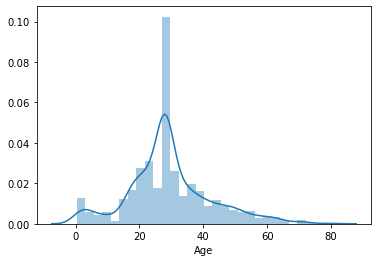

In [20]:
sns.distplot(train_df['Age'])

The distribution plot shows that the majority of the people were in the age group 20 to 40. 

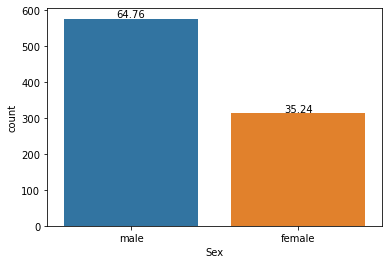

In [21]:
total = float(len(train_df))
ax = sns.countplot(train_df['Sex']) # for Seaborn version 0.7 and more
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
show()

In the total passenger 64.76% were male and 35.24% people were female. 

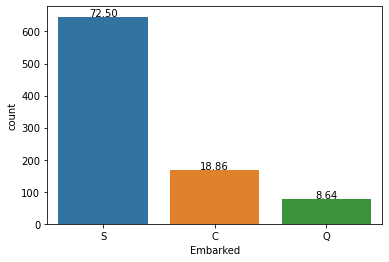

In [22]:
total = float(len(train_df))
ax = sns.countplot(train_df['Embarked']) # for Seaborn version 0.7 and more
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
show()

Most of the traveller(72.50%) have embarked at S 

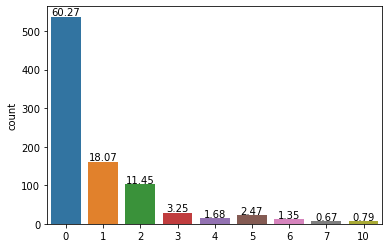

In [23]:
total = float(len(train_df))
ax = sns.countplot(train_df['SibSp']+train_df['Parch']) # for Seaborn version 0.7 and more
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
show()

60% of the people have travelled alone. This cannot be exact number as mentione in the data description children who have travelled with their nanny Parch is mentioned as 0. But we can say that a majority of the people have travelled alone.

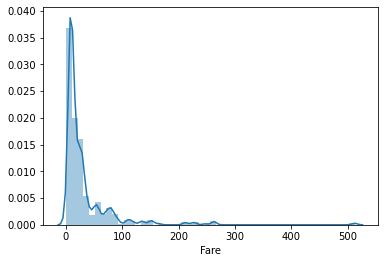

In [24]:
sns.distplot(train_df['Fare'])

The fare column shows the same prize shows something interesting. We do have fare starting from 0 to 500. The highest probability 
for the reason for the fare to be zero is they might be the crew members of the ship and the highest fare might be due to large nummber of people travelling together, as the fare displayed is at the itinerary level. 

In [25]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,female,35.0,1,0,113803,53.1000,S
4,5,0,3,male,35.0,0,0,373450,8.0500,S


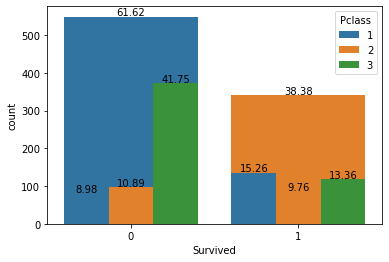

In [26]:
sns.countplot(x='Survived',data=train_df)
total = float(len(train_df))
ax = sns.countplot(x='Survived',hue='Pclass',data=train_df) # for Seaborn version 0.7 and more
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
show()

Overall only 38.38 percentage of the travellers survived and the percentage split with respect to Pclass is shown.

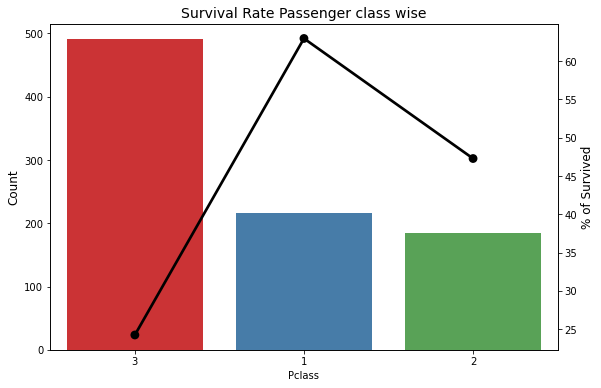

In [27]:
p_cont1 = pd.crosstab(train_df['Pclass'], train_df['Survived'], normalize='index') * 100
p_cont1 = p_cont1.reset_index()
p_cont1.rename(columns={0:'Dead', 1:'Survived'}, inplace=True)


listv = []
for var in train_df['Pclass'].unique():
    listv.append(var)

plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)

g1= sns.countplot(x='Pclass',  data=train_df,order=listv,palette="Set1")
gt = g1.twinx()
gt = sns.pointplot(x='Pclass', y='Survived', data=p_cont1, color='black', legend=False,order=listv)
gt.set_ylabel("% of Survived", fontsize=12)

g1.set_title("Survival Rate Passenger class wise", fontsize=14)
g1.set_ylabel("Count", fontsize=12)


 

plt.show()

The above graph shows, the survival rate is much higher in the class 1 travellers and very low for class 3

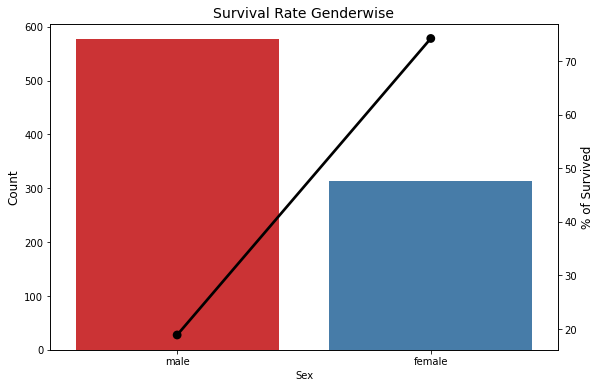

In [28]:
p_cont1 = pd.crosstab(train_df['Sex'], train_df['Survived'], normalize='index') * 100
p_cont1 = p_cont1.reset_index()
p_cont1.rename(columns={0:'Dead', 1:'Survived'}, inplace=True)


listv = []
for var in train_df['Sex'].unique():
    listv.append(var)

plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)

g1= sns.countplot(x='Sex',  data=train_df,order=listv,palette="Set1")
gt = g1.twinx()
gt = sns.pointplot(x='Sex', y='Survived', data=p_cont1, color='black', legend=False,order=listv)
gt.set_ylabel("% of Survived", fontsize=12)

g1.set_title("Survival Rate Genderwise", fontsize=14)
g1.set_ylabel("Count", fontsize=12)


 

plt.show()

The above graph shows that the number of male passengers were almost double but more than 70% of the female passengers survived whereas only 20 % of the men survived. 

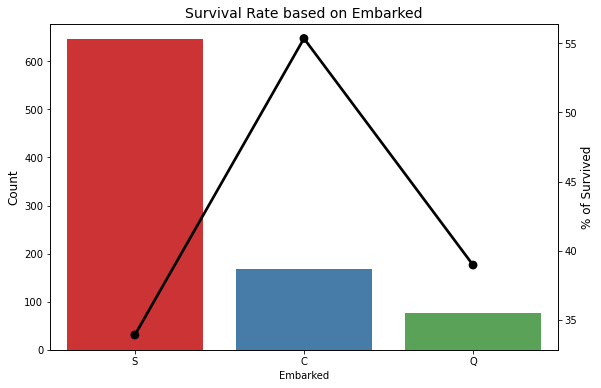

In [29]:
p_cont1 = pd.crosstab(train_df['Embarked'], train_df['Survived'], normalize='index') * 100
p_cont1 = p_cont1.reset_index()
p_cont1.rename(columns={0:'Dead', 1:'Survived'}, inplace=True)


listv = []
for var in train_df['Embarked'].unique():
    listv.append(var)

plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)

g1= sns.countplot(x='Embarked',  data=train_df,order=listv,palette="Set1")
gt = g1.twinx()
gt = sns.pointplot(x='Embarked', y='Survived', data=p_cont1, color='black', legend=False,order=listv)
gt.set_ylabel("% of Survived", fontsize=12)

g1.set_title("Survival Rate based on Embarked", fontsize=14)
g1.set_ylabel("Count", fontsize=12)


 

plt.show()

In [30]:
train_df[train_df['Fare']==0]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
179,180,0,3,male,36.0,0,0,LINE,0.0,S
263,264,0,1,male,40.0,0,0,112059,0.0,S
271,272,1,3,male,25.0,0,0,LINE,0.0,S
277,278,0,2,male,28.0,0,0,239853,0.0,S
302,303,0,3,male,19.0,0,0,LINE,0.0,S
413,414,0,2,male,28.0,0,0,239853,0.0,S
466,467,0,2,male,28.0,0,0,239853,0.0,S
481,482,0,2,male,28.0,0,0,239854,0.0,S
597,598,0,3,male,49.0,0,0,LINE,0.0,S
633,634,0,1,male,28.0,0,0,112052,0.0,S


Interestingly for all the passengers who have 0 as fare has embarked at S, they are all male, all are travelling alone and none of them have survived. possibillly  they could be the crew members. All the travller with ticket mentioned as Line are in Class 3. They could be lower level crew member

In [31]:
def personclassifier(x):
    age, sex = x
    if age <=12:
        return 'Child'
    if age > 12 and age <=19:
        return 'Teenager'
    if age >19 and age <=30:
        return 'Young Adult'
    if age >30 and age <= 45:
        return 'Mid aged Adult'
    if age >45:
        return 'Old Adults'
    
    
    

In [32]:
def singletraveller(x):
    single  = x
    if single ==0:
        return 'Yes'
    else:
        return 'No'   

In [33]:
train_df['Single_Traveller'] = train_df['SibSp']+train_df['Parch']

In [34]:
train_df['Single_Traveller'] = train_df['Single_Traveller'].apply(singletraveller)

In [35]:
test_df['Single_Traveller'] = test_df['SibSp']+test_df['Parch']

In [36]:
test_df['Single_Traveller'] = test_df['Single_Traveller'].apply(singletraveller)

In [37]:
train_df['Person'] = train_df[['Age','Sex']].apply(personclassifier,axis=1)

In [38]:
test_df['Person'] = test_df[['Age','Sex']].apply(personclassifier,axis=1)

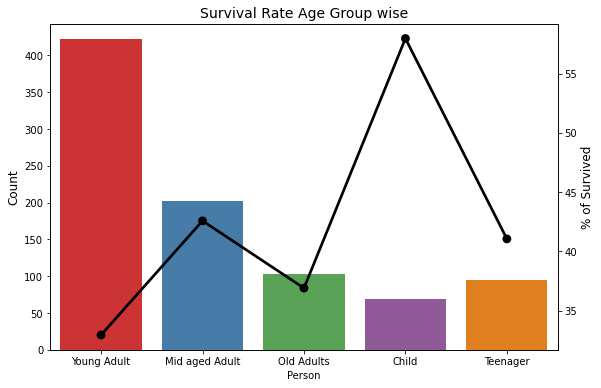

In [39]:
p_cont1 = pd.crosstab(train_df['Person'], train_df['Survived'], normalize='index') * 100
p_cont1 = p_cont1.reset_index()
p_cont1.rename(columns={0:'Dead', 1:'Survived'}, inplace=True)


listv = []
for var in train_df['Person'].unique():
    listv.append(var)

plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)

g1= sns.countplot(x='Person',  data=train_df,order=listv,palette="Set1")
gt = g1.twinx()
gt = sns.pointplot(x='Person', y='Survived', data=p_cont1, color='black', legend=False,order=listv)
gt.set_ylabel("% of Survived", fontsize=12)

g1.set_title("Survival Rate Age Group wise", fontsize=14)
g1.set_ylabel("Count", fontsize=12)


 

plt.show()

The above graph clearly shows that, young adults are the majority population and the survival rate is much lesser in that group and children having the highest survival rate.

In [40]:
p_cont1 = pd.crosstab([train_df['Person'],train_df['Sex']], train_df['Survived'], normalize='index') * 100
p_cont1

Survived                       0          1
Person         Sex                         
Child          female  40.625000  59.375000
               male    43.243243  56.756757
Mid aged Adult female  21.917808  78.082192
               male    77.519380  22.480620
Old Adults     female  13.333333  86.666667
               male    83.561644  16.438356
Teenager       female  20.930233  79.069767
               male    90.384615   9.615385
Young Adult    female  28.676471  71.323529
               male    85.314685  14.685315

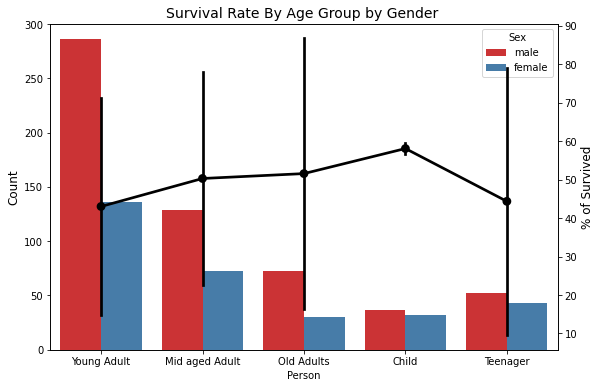

In [41]:
p_cont1 = pd.crosstab([train_df['Person'],train_df['Sex']], train_df['Survived'], normalize='index') * 100
p_cont1 = p_cont1.reset_index()
p_cont1.rename(columns={0:'Dead', 1:'Survived'}, inplace=True)


listv = []
for var in train_df['Person'].unique():
    listv.append(var)

plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)

g1= sns.countplot(x='Person', hue='Sex', data=train_df,order=listv,palette="Set1")
gt = g1.twinx()
gt = sns.pointplot(x='Person', y='Survived', data=p_cont1, color='black', legend=False,order=listv)
gt.set_ylabel("% of Survived", fontsize=12)

g1.set_title("Survival Rate By Age Group by Gender ", fontsize=14)
g1.set_ylabel("Count", fontsize=12)


 

plt.show()

In every age group the count of male is higher whereas in teenager group alone female traveller are slightly higher. Breaking the survival rate by age group by sex, children seem to have a farely same survival rate in both the gender, where as in all age group female seem to have hiher survival rate where in the teenager male having the least survival rate (less than 10%) and females in the Old Adult group have the higher survival rate with 86.66%.

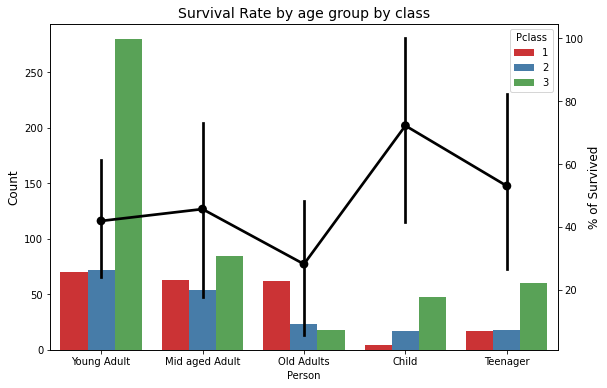

In [42]:
p_cont1 = pd.crosstab([train_df['Person'],train_df['Pclass']], train_df['Survived'], normalize='index') * 100
p_cont1 = p_cont1.reset_index()
p_cont1.rename(columns={0:'Dead', 1:'Survived'}, inplace=True)


listv = []
for var in train_df['Person'].unique():
    listv.append(var)

plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)

g1= sns.countplot(x='Person', hue='Pclass', data=train_df,order=listv,palette="Set1")
gt = g1.twinx()
gt = sns.pointplot(x='Person', y='Survived', data=p_cont1, color='black', legend=False,order=listv)
gt.set_ylabel("% of Survived", fontsize=12)

g1.set_title("Survival Rate by age group by class", fontsize=14)
g1.set_ylabel("Count", fontsize=12)


 

plt.show()

In [43]:
p_cont1 = pd.crosstab([train_df['Person'],train_df['Pclass']], train_df['Survived'], normalize='index') * 100
p_cont1

Survived                       0           1
Person         Pclass                       
Child          1       25.000000   75.000000
               2        0.000000  100.000000
               3       58.333333   41.666667
Mid aged Adult 1       26.984127   73.015873
               2       53.703704   46.296296
               3       82.352941   17.647059
Old Adults     1       51.612903   48.387097
               2       69.565217   30.434783
               3       94.444444    5.555556
Teenager       1       17.647059   82.352941
               2       50.000000   50.000000
               3       73.333333   26.666667
Young Adult    1       38.571429   61.428571
               2       59.722222   40.277778
               3       76.071429   23.928571

Children in class 2 have 100% survival rate and old adults in class 3 have the least survival rate with just 5.55%

In [44]:
test_df.isnull().sum()

PassengerId         0
Pclass              0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                1
Embarked            0
Single_Traveller    0
Person              0
dtype: int64

In [45]:
test_df['Fare'].fillna(test_df['Fare'].median(),inplace=True)

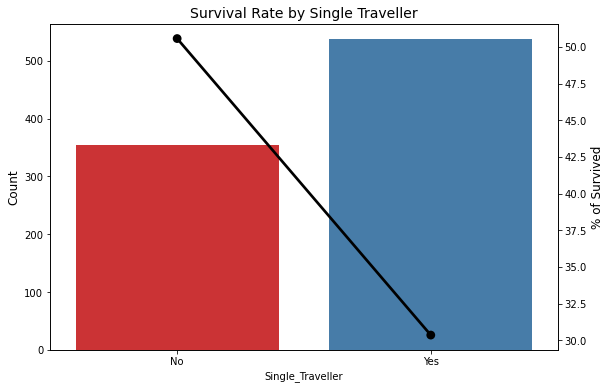

In [46]:
p_cont1 = pd.crosstab(train_df['Single_Traveller'], train_df['Survived'], normalize='index') * 100
p_cont1 = p_cont1.reset_index()
p_cont1.rename(columns={0:'Dead', 1:'Survived'}, inplace=True)


listv = []
for var in train_df['Single_Traveller'].unique():
    listv.append(var)

plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)

g1= sns.countplot(x='Single_Traveller', data=train_df,order=listv,palette="Set1")
gt = g1.twinx()
gt = sns.pointplot(x='Single_Traveller', y='Survived', data=p_cont1, color='black', legend=False,order=listv)
gt.set_ylabel("% of Survived", fontsize=12)

g1.set_title("Survival Rate by Single Traveller", fontsize=14)
g1.set_ylabel("Count", fontsize=12)


 

plt.show()

The count of single traveller seems to be high,but only 30 percentage of the single traveller survived where as more than 50% of the  traveller who travelled with someone have survived. 

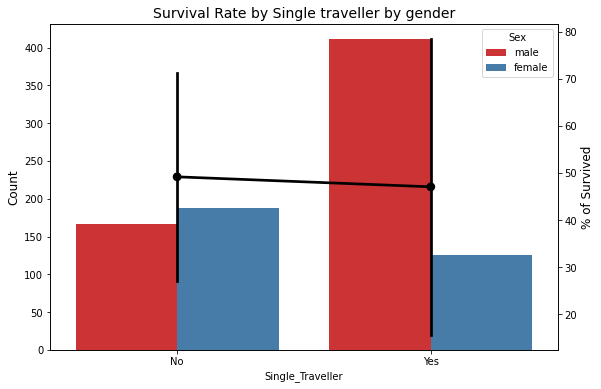

In [47]:
p_cont1 = pd.crosstab([train_df['Single_Traveller'],train_df['Sex']], train_df['Survived'], normalize='index') * 100
p_cont1 = p_cont1.reset_index()
p_cont1.rename(columns={0:'Dead', 1:'Survived'}, inplace=True)


listv = []
for var in train_df['Single_Traveller'].unique():
    listv.append(var)

plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)

g1= sns.countplot(x='Single_Traveller', hue='Sex', data=train_df,order=listv,palette="Set1")
gt = g1.twinx()
gt = sns.pointplot(x='Single_Traveller', y='Survived', data=p_cont1, color='black', legend=False,order=listv)
gt.set_ylabel("% of Survived", fontsize=12)

g1.set_title("Survival Rate by Single traveller by gender", fontsize=14)
g1.set_ylabel("Count", fontsize=12)


 

plt.show()

Though the number of single traveller female is very less almost 80% of them have survived, whereas only 15% of male single traveller have survived. 

In [48]:
p_cont1 = pd.crosstab([train_df['Single_Traveller'],train_df['Sex']], train_df['Survived'], normalize='index') * 100
p_cont1

Survived                         0          1
Single_Traveller Sex                         
No               female  28.723404  71.276596
                 male    72.891566  27.108434
Yes              female  21.428571  78.571429
                 male    84.428224  15.571776

The nummber female single traveller are very less.

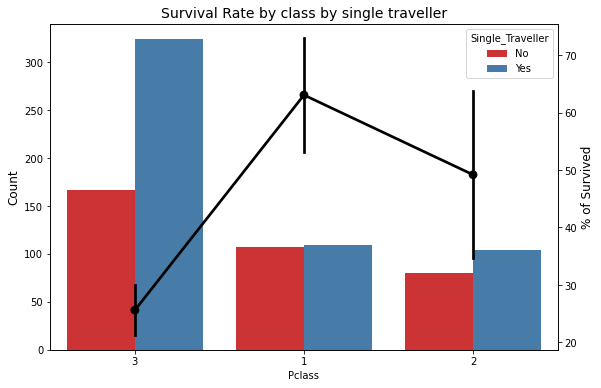

In [49]:
p_cont1 = pd.crosstab([train_df['Pclass'],train_df['Single_Traveller']], train_df['Survived'], normalize='index') * 100
p_cont1 = p_cont1.reset_index()
p_cont1.rename(columns={0:'Dead', 1:'Survived'}, inplace=True)


listv = []
for var in train_df['Pclass'].unique():
    listv.append(var)

plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)

g1= sns.countplot(x='Pclass', hue='Single_Traveller', data=train_df,order=listv,palette="Set1")
gt = g1.twinx()
gt = sns.pointplot(x='Pclass', y='Survived', data=p_cont1, color='black', legend=False,order=listv)
gt.set_ylabel("% of Survived", fontsize=12)

g1.set_title("Survival Rate by class by single traveller", fontsize=14)
g1.set_ylabel("Count", fontsize=12)


 

plt.show()

In [50]:
p_cont1 = pd.crosstab([train_df['Pclass'],train_df['Single_Traveller']], train_df['Survived'], normalize='index') * 100
p_cont1

Survived                         0          1
Pclass Single_Traveller                      
1      No                27.102804  72.897196
       Yes               46.788991  53.211009
2      No                36.250000  63.750000
       Yes               65.384615  34.615385
3      No                70.059880  29.940120
       Yes               78.703704  21.296296

By all means single traveller has less survival rate

Creating the model without any outlier treatment.

In [51]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Single_Traveller,Person
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,No,Young Adult
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,No,Mid aged Adult
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Yes,Young Adult
3,4,1,1,female,35.0,1,0,113803,53.1000,S,No,Mid aged Adult
4,5,0,3,male,35.0,0,0,373450,8.0500,S,Yes,Mid aged Adult


In [52]:
train_df.drop('Ticket',axis=1,inplace=True)
test_df.drop('Ticket',axis=1,inplace=True)
#train_df.drop(['SibSp','Parch'],axis=1,inplace=True)
#test_df.drop(['SibSp','Parch'],axis=1,inplace=True)

In [53]:
col = []
for c in train_df.columns:
    if train_df[c].dtypes=='object':
        col.append(c)
        

train_df_dummies = pd.get_dummies(train_df , columns=col, drop_first=True)

In [54]:
corr_mat = train_df_dummies.corr()


In [55]:
train_df_dummies.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Single_Traveller_Yes,Person_Mid aged Adult,Person_Old Adults,Person_Teenager,Person_Young Adult
PassengerId,1.000000,-0.005007,-0.035144,0.034212,-0.057527,-0.001652,0.012658,0.042939,-0.033606,0.022204,0.057462,0.039247,0.038757,-0.007762,-0.044753
Survived,-0.005007,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,-0.543351,0.003650,-0.149683,-0.203367,0.046655,-0.011082,0.018958,-0.106214
Pclass,-0.035144,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,0.131900,0.221009,0.074053,0.135207,-0.129423,-0.318370,0.059530,0.214539
Age,0.034212,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,0.081163,-0.031415,-0.006729,0.171647,0.314341,0.704521,-0.322459,-0.222335
SibSp,-0.057527,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,-0.114631,-0.026354,0.068734,-0.584471,-0.076971,-0.069652,0.014235,-0.089146
Parch,-0.001652,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,-0.245489,-0.081228,0.060814,-0.583398,0.039655,-0.049253,0.007893,-0.203775
Fare,0.012658,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,-0.182333,-0.117216,-0.162184,-0.271832,0.098783,0.089407,-0.001543,-0.137053
Sex_male,0.042939,-0.543351,0.131900,0.081163,-0.114631,-0.245489,-0.182333,1.000000,-0.074115,0.119224,0.303646,-0.010170,0.046279,-0.072473,0.059843
Embarked_Q,-0.033606,0.003650,0.221009,-0.031415,-0.026354,-0.081228,-0.117216,-0.074115,1.000000,-0.499421,0.086464,-0.080675,-0.073719,-0.028600,0.148243
Embarked_S,0.022204,-0.149683,0.074053,-0.006729,0.068734,0.060814,-0.162184,0.119224,-0.499421,1.000000,0.029074,0.099321,-0.005329,0.017285,-0.110562


In [56]:
# Getting the columns that are having multi collinearity
# Creating a dataframe with correlated column, the correlation value and the source column to which it is correlated
# Filtering only those that are correlated more than 96%
multi_col_df = pd.DataFrame(columns=['corr_col','corr_val','source_col'])
for i in corr_mat:
    temp_df = pd.DataFrame(corr_mat[corr_mat[i]>0.9][i])
    temp_df = temp_df.reset_index()
    temp_df['source_col'] = i
    temp_df.columns = ['corr_col','corr_val','source_col']
    multi_col_df = pd.concat((multi_col_df,temp_df),axis=0)

In [57]:
multi_col_df

,corr_col,corr_val,source_col
0,PassengerId,1.0,PassengerId
0,Survived,1.0,Survived
0,Pclass,1.0,Pclass
0,Age,1.0,Age
0,SibSp,1.0,SibSp
0,Parch,1.0,Parch
0,Fare,1.0,Fare
0,Sex_male,1.0,Sex_male
0,Embarked_Q,1.0,Embarked_Q
0,Embarked_S,1.0,Embarked_S


In [58]:
X = train_df_dummies.drop(['Survived','PassengerId'],axis=1)
X_id = train_df_dummies['PassengerId']
y = train_df_dummies['Survived']

In [59]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X,y, test_size=0.20,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.20,random_state=1)

In [60]:
X_trainval_z =X_trainval.apply(zscore)
X_train_z =X_train.apply(zscore)
X_val_z =X_val.apply(zscore)
X_test_z =X_test.apply(zscore)
X_z = X.apply(zscore)

In [61]:
# Grid Search based on Max_features, Min_Samples_Split and Max_Depth
param_grid = [
{
'n_neighbors': list(range(1,50)),
'algorithm': ['auto', 'ball_tree', 'kd_tree','brute'],
'leaf_size': [10,15,20,30],
'n_jobs': [-1], 
'weights' : ['uniform','distance']
}
]



In [62]:
import multiprocessing
gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=multiprocessing.cpu_count(),cv=3)
gs.fit(X_train_z, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'leaf_size': [10, 15, 20, 30], 'n_jobs': [-1],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,


In [63]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
                     weights='uniform')

In [64]:
gs.best_score_

0.8031189083820663

In [65]:
knn_clfr = KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='uniform')

In [66]:
sfs1 = sfs(knn_clfr, k_features=8, forward=False, scoring='accuracy', cv=10,n_jobs=-1)

In [67]:
sfs1 = sfs1.fit(X_train_z.values, y_train.values)

In [68]:
X_train_z.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Single_Traveller_Yes,Person_Mid aged Adult,Person_Old Adults,Person_Teenager,Person_Young Adult
454,0.852414,-0.128624,-0.487624,-0.487479,-0.509601,0.733374,-0.317144,0.617307,0.820688,-0.538748,-0.389643,-0.346524,1.101820
167,0.852414,1.116903,0.446578,4.846668,-0.088809,-1.363560,-0.317144,0.617307,-1.218489,1.856155,-0.389643,-0.346524,-0.907589
657,0.852414,0.164441,0.446578,0.846058,-0.351671,-1.363560,3.153143,-1.619939,-1.218489,1.856155,-0.389643,-0.346524,-0.907589
364,0.852414,-0.128624,0.446578,-0.487479,-0.351671,0.733374,3.153143,-1.619939,-1.218489,-0.538748,-0.389643,-0.346524,1.101820
99,-0.345175,0.310974,0.446578,-0.487479,-0.129087,0.733374,-0.317144,0.617307,-1.218489,1.856155,-0.389643,-0.346524,-0.907589


In [69]:
sfs1.get_metric_dict()

{13: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
  'cv_scores': array([0.8245614 , 0.85964912, 0.78947368, 0.78947368, 0.85964912,
         0.78947368, 0.77192982, 0.8245614 , 0.75438596, 0.80357143]),
  'avg_score': 0.8066729323308272,
  'feature_names': ('0',
   '1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11',
   '12'),
  'ci_bound': 0.02473470594792698,
  'std_dev': 0.03330318385604301,
  'std_err': 0.011101061285347668},
 12: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12),
  'cv_scores': array([0.8245614 , 0.87719298, 0.84210526, 0.8245614 , 0.87719298,
         0.78947368, 0.80701754, 0.84210526, 0.77192982, 0.80357143]),
  'avg_score': 0.8259711779448621,
  'feature_names': ('0',
   '1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '9',
   '10',
   '11',
   '12'),
  'ci_bound': 0.02450442102063386,
  'std_dev': 0.03299312473146462,
  'std_err': 0.010997708243821538},
 11: {'feature_idx': (0, 1, 2, 4, 5, 6, 7, 9,

In [70]:
columnList = list(X_train_z.columns)
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 2, 5, 7, 9, 10, 11, 12]


In [71]:
subsetColumnList = [columnList[i] for i in feat_cols] 
print(subsetColumnList)

['Pclass', 'SibSp', 'Sex_male', 'Embarked_S', 'Person_Mid aged Adult', 'Person_Old Adults', 'Person_Teenager', 'Person_Young Adult']


In [72]:
train_df_dummies.dtypes

PassengerId                int64
Survived                   int64
Pclass                     int64
Age                      float64
SibSp                      int64
Parch                      int64
Fare                     float64
Sex_male                   uint8
Embarked_Q                 uint8
Embarked_S                 uint8
Single_Traveller_Yes       uint8
Person_Mid aged Adult      uint8
Person_Old Adults          uint8
Person_Teenager            uint8
Person_Young Adult         uint8
dtype: object

In [73]:
train_df_dummies_knn = train_df_dummies.drop(['Age','Parch','Embarked_Q','Single_Traveller_Yes'],axis=1)


In [74]:
train_df_dummies_knn.head()

,PassengerId,Survived,Pclass,SibSp,Fare,Sex_male,Embarked_S,Person_Mid aged Adult,Person_Old Adults,Person_Teenager,Person_Young Adult
0,1,0,3,1,7.2500,1,1,0,0,0,1
1,2,1,1,1,71.2833,0,0,1,0,0,0
2,3,1,3,0,7.9250,0,1,0,0,0,1
3,4,1,1,1,53.1000,0,1,1,0,0,0
4,5,0,3,0,8.0500,1,1,1,0,0,0


In [75]:
X_knn = train_df_dummies_knn.drop(['PassengerId','Survived'],axis=1)
X_id_knn = train_df_dummies_knn['PassengerId']
y_knn = train_df_dummies_knn['Survived']

In [76]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=1)
X_res,y_res=smk.fit_sample(X_knn,y_knn)

Using TensorFlow backend.


In [77]:
X_trainval_knn, X_test_knn, y_trainval_knn, y_test_knn = train_test_split(X_res,y_res, test_size=0.20,random_state=1)
X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_trainval_knn,y_trainval_knn, test_size=0.20,random_state=1)

In [78]:
X_trainval_z_knn =X_trainval_knn.apply(zscore)
X_train_z_knn =X_train_knn.apply(zscore)
X_val_z_knn =X_val_knn.apply(zscore)
X_test_z_knn =X_test_knn.apply(zscore)
X_z_knn = X_res.apply(zscore)

In [79]:
import multiprocessing
gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=multiprocessing.cpu_count(),cv=10)
gs.fit(X_train_z_knn, y_train_knn)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'leaf_size': [10, 15, 20, 30], 'n_jobs': [-1],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,

In [80]:
gs.best_estimator_

KNeighborsClassifier(algorithm='brute', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='distance')

In [81]:
gs.best_score_

0.855684811237928

In [82]:
knnclfr = KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='uniform')

In [83]:
knnclfr.fit(X_train_z_knn, y_train_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='uniform')

In [84]:
y_predict_knn = knnclfr.predict(X_val_z_knn)

In [85]:
print(knnclfr.score(X_train_z_knn,y_train_knn))
print(knnclfr.score(X_val_z_knn,y_val_knn))
print(metrics.classification_report(y_val_knn,y_predict_knn))
print(metrics.confusion_matrix(y_val_knn,y_predict_knn))


0.8705357142857143
0.863905325443787
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        88
           1       0.90      0.80      0.85        81

    accuracy                           0.86       169
   macro avg       0.87      0.86      0.86       169
weighted avg       0.87      0.86      0.86       169

[[81  7]
 [16 65]]


In [86]:
knnclfr.fit(X_trainval_z_knn, y_trainval_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='uniform')

In [87]:
y_predict_knn = knnclfr.predict(X_test_z_knn)

In [88]:
print(knnclfr.score(X_trainval_z_knn, y_trainval_knn))
print(knnclfr.score(X_test_z_knn,y_test_knn))
print(metrics.classification_report(y_test_knn,y_predict_knn))
print(metrics.confusion_matrix(y_test_knn,y_predict_knn))


0.8715814506539834
0.7914691943127962
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       115
           1       0.81      0.71      0.76        96

    accuracy                           0.79       211
   macro avg       0.79      0.78      0.79       211
weighted avg       0.79      0.79      0.79       211

[[99 16]
 [28 68]]


In [89]:
knnclfr.fit(X_z_knn,y_res)

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='uniform')

In [90]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Single_Traveller,Person
0,892,3,male,34.5,0,0,7.8292,Q,Yes,Mid aged Adult
1,893,3,female,47.0,1,0,7.0000,S,No,Old Adults
2,894,2,male,62.0,0,0,9.6875,Q,Yes,Old Adults
3,895,3,male,27.0,0,0,8.6625,S,Yes,Young Adult
4,896,3,female,22.0,1,1,12.2875,S,No,Young Adult


In [91]:
test_df['Fare'].fillna(test_df['Fare'].median(),inplace=True)

In [92]:
col = []
for c in test_df.columns:
    if test_df[c].dtypes=='object':
        col.append(c)
        

test_df_dummies = pd.get_dummies(test_df , columns=col, drop_first=True)

In [93]:
test_df_dummies.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Single_Traveller_Yes,Person_Mid aged Adult,Person_Old Adults,Person_Teenager,Person_Young Adult
0,892,3,34.5,0,0,7.8292,1,1,0,1,1,0,0,0
1,893,3,47.0,1,0,7.0000,0,0,1,0,0,1,0,0
2,894,2,62.0,0,0,9.6875,1,1,0,1,0,1,0,0
3,895,3,27.0,0,0,8.6625,1,0,1,1,0,0,0,1
4,896,3,22.0,1,1,12.2875,0,0,1,0,0,0,0,1


In [94]:
test_df_dummies_knn = test_df_dummies.drop(['Age','Parch','Embarked_Q','Single_Traveller_Yes'],axis=1,inplace=True)


In [95]:
test_df_dummies_knn

In [96]:
X_test_knn = test_df_dummies.drop(['PassengerId'],axis=1)
X_test_id_knn = test_df_dummies['PassengerId']


In [97]:
X_test_knn =X_test_knn.apply(zscore)


In [98]:
y_predict = knnclfr.predict(X_test_knn)

In [99]:
final_pred_df = pd.DataFrame(y_predict)
final_pred_df.columns = ['Survived']
X_test_id_knn = pd.DataFrame(X_test_id_knn)
final_pred = X_test_id_knn.merge(final_pred_df, left_index=True, right_index=True)
final_pred.shape
final_pred.to_csv('csv_to_submit2602-2.csv', index = False)

In [100]:
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()


In [101]:
lab_enc = preprocessing.LabelEncoder()

In [102]:
col = []
for c in train_df.columns:
    if train_df[c].dtypes=='object':
        train_df[c] = lab_enc.fit_transform(train_df[c])
        print("Column {} has been encoded".format(c))

Column Sex has been encoded
Column Embarked has been encoded
Column Single_Traveller has been encoded
Column Person has been encoded


In [103]:
col = []
for c in test_df.columns:
    if test_df[c].dtypes=='object':
        test_df[c] = lab_enc.fit_transform(test_df[c])
        print("Column {} has been encoded".format(c))

Column Sex has been encoded
Column Embarked has been encoded
Column Single_Traveller has been encoded
Column Person has been encoded


In [104]:
X = train_df.drop(['Survived','PassengerId'],axis=1)
X_id = train_df['PassengerId']
y = train_df['Survived']

In [105]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=1)
X_res,y_res=smk.fit_sample(X,y)

In [106]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_res,y_res, test_size=0.20,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.20,random_state=1)

In [107]:
X_trainval_z =X_trainval.apply(zscore)
X_train_z =X_train.apply(zscore)
X_val_z =X_val.apply(zscore)
X_test_z =X_test.apply(zscore)
X_z = X_res.apply(zscore)

In [108]:
# Grid Search based on Max_features, Min_Samples_Split and Max_Depth
param_grid = [
{
'n_neighbors': list(range(1,50)),
'algorithm': ['auto', 'ball_tree', 'kd_tree','brute'],
'leaf_size': [10,15,20,30],
'n_jobs': [-1], 
'weights' : ['uniform','distance']
}
]

In [109]:
import multiprocessing
gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=multiprocessing.cpu_count(),cv=3)
gs.fit(X_train_z, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'leaf_size': [10, 15, 20, 30], 'n_jobs': [-1],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,


In [110]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [111]:
gs.best_score_

0.8436261843238587

In [112]:
knn_clfr = KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [113]:
train_df.shape

(891, 11)

In [114]:
sfs1 = sfs(knn_clfr, k_features=6, forward=True, scoring='accuracy', cv=10,n_jobs=-1)

In [115]:
sfs1 = sfs1.fit(X_train_z.values, y_train.values)

In [116]:
sfs1.get_metric_dict()

{1: {'feature_idx': (1,),
  'cv_scores': array([0.47692308, 0.90769231, 0.76923077, 0.84615385, 0.75384615,
         0.76923077, 0.75      , 0.8125    , 0.84375   , 0.78125   ]),
  'avg_score': 0.7710576923076923,
  'feature_names': ('1',),
  'ci_bound': 0.08090986874494639,
  'std_dev': 0.10893827645471116,
  'std_err': 0.03631275881823705},
 2: {'feature_idx': (1, 2),
  'cv_scores': array([0.75384615, 0.87692308, 0.75384615, 0.84615385, 0.8       ,
         0.76923077, 0.796875  , 0.8125    , 0.8125    , 0.84375   ]),
  'avg_score': 0.8065625000000001,
  'feature_names': ('1', '2'),
  'ci_bound': 0.02882271931280764,
  'std_dev': 0.038807347155303575,
  'std_err': 0.01293578238510119},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([0.81538462, 0.84615385, 0.8       , 0.84615385, 0.83076923,
         0.73846154, 0.796875  , 0.84375   , 0.828125  , 0.875     ]),
  'avg_score': 0.8220673076923077,
  'feature_names': ('0', '1', '2'),
  'ci_bound': 0.026469097831268495,
  'std_dev':

In [117]:
columnList = list(X_train_z.columns)
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 5, 7, 8]


In [118]:
subsetColumnList = [columnList[i] for i in feat_cols] 
print(subsetColumnList)

['Pclass', 'Sex', 'Age', 'Fare', 'Single_Traveller', 'Person']


In [119]:
train_df.head(1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Single_Traveller,Person
0,1,0,3,1,22.0,1,0,7.25,2,0,4


In [120]:
train_df_bkp = train_df.copy()
test_df_bkp = test_df.copy()

In [121]:
X_knn = train_df[['Pclass', 'Sex', 'Age', 'Fare', 'Single_Traveller', 'Person']]
X_id_knn = train_df['PassengerId']
y_knn = train_df['Survived']

In [122]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=1)
X_res,y_res=smk.fit_sample(X_knn,y_knn)

In [123]:
X_trainval_knn, X_test_knn, y_trainval_knn, y_test_knn = train_test_split(X_res,y_res, test_size=0.20,random_state=1)
X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_trainval_knn,y_trainval_knn, test_size=0.20,random_state=1)

In [124]:
X_trainval_z_knn =X_trainval_knn.apply(zscore)
X_train_z_knn =X_train_knn.apply(zscore)
X_val_z_knn =X_val_knn.apply(zscore)
X_test_z_knn =X_test_knn.apply(zscore)
X_z_knn = X_res.apply(zscore)